## Introduction

In this notebook, we will take an intial look at the overall ArI dataset that is used for optimization and set some constraints for the hyperparameters.

General Note: The output of the cells containing scope runs using Benchmark().collect_data() was deleted as it only provided information about the calculation progress. The cells however were left untouched to allow reproducibility of the results.

## Imposed constraints

For the scope algorithm being developed here to be useful, we envisioned that we needed to set constraints for both the scope size and the number of rounds of experiments to avoid excessive experimental labor and time requirements, as well as to increase practicality.

We decided to limit the number of scope samples to 30 and the number of experimental rounds to 10.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.benchmark import Benchmark
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import ast
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

wdir = Path(".")

## Trends for the average objective and Vendi score (as a measurement of substrate diversity)

Data collection for a balanced Expected Improvement acqusition function for some different batch sizes and amounts of Vendi pruning

In [2]:
# # dictionary with the different batches and the possible Vendi pruning fractions (larger batch = less rounds --> more pruning possible without exhausting the seach space)
# batch_pruning_combinations = {1: [0,10], 2: [0,10,20,30], 3: [0,10,20,30,40], 4: [0,10,20,30,40,50]}
# for batch in batch_pruning_combinations.keys():
#     Benchmark().collect_data(
#         filename_labelled = f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered.csv",  # csv with labelled reaction space
#         name_results = f"./Results_Data/Reaction_Space_Size_Dependence/Full_Reaction_Space/30balanced_b{batch}",  # Name of the folder where the results will be saved.
#         objectives=['rate'],  # Objectives to be optimized.
#         budget = 30,  # Total number of experiments to be performed
#         batches= [batch],  # Number of experiments in each round.
#         Vendi_pruning_fractions = batch_pruning_combinations[batch],  # Vendi pruning values to be tested
#         seeds = 20,  # number of repetitions for each combination of batch, and Vendi_pruning_fraction
#         acquisition_function_mode= "balanced",  # Acq. fct. to use ("balanced" = EI)
#         pruning_metric= "vendi_batch",  # pruning before every batch of experiments
#         init_sampling_method="random")  # random initiation

In [3]:
def generate_heatmap_summary(results_folder, budget, report_types=["vendi","rate"]):

    wdir = Path(".")
    df_list_vendi = []
    df_list_obj = []

    for batch in [1,2,3,4]:
        dfs = {}
        for info_type in ["vendi","obj[rate]"]:
            csv_filename_results = wdir.joinpath(f"./{results_folder}/30balanced_b{batch}/benchmark_{info_type}_av.csv")
            dfs[info_type] = pd.read_csv(csv_filename_results,index_col=0,header=0, float_precision = "round_trip")
            dfs[info_type] = dfs[info_type].applymap(lambda x: ast.literal_eval(x))
            if info_type == "vendi": # contains the Vendi scores for each round in each element
                dfs[info_type] = dfs[info_type].applymap(lambda x: x[-1])  # only keep the final Vendi score
            else: # contains the average objective values for each round in each element
                for batch in list(dfs[info_type].index):
                    if budget % batch == 0:  
                        dfs[info_type].loc[batch] = dfs[info_type].loc[batch].apply(lambda x: sum(x)/len(x))  # get the overall objective value average
                    else:
                        # calculate the average yield while considering that the size of the last batch in the run was smaller
                        dfs[info_type].loc[batch] = dfs[info_type].loc [batch].apply(lambda x: (sum(x[:-1])*batch+x[-1]*(budget % batch))/budget)
            dfs[info_type] = dfs[info_type].apply(pd.to_numeric)

        df_list_vendi.append(dfs["vendi"])
        df_list_obj.append(dfs["obj[rate]"])

    df_combined_vendi = pd.concat(df_list_vendi)
    df_combined_obj = pd.concat(df_list_obj)

    def create_plot(data,label):
        plt.figure(figsize=(15,4.5))
        heatmap = sns.heatmap(data,annot=True, fmt=".3f", linewidths=1,cmap='Doyle_cont',cbar_kws={'label': label})
        heatmap.set_xlabel("Vendi pruning fraction in %", fontsize=16)
        heatmap.set_ylabel("Batch size",fontsize=16)
        heatmap.tick_params(length=0,labelsize=14)
        colorbar = heatmap.collections[0].colorbar
        colorbar.set_label(label,fontsize=16)
        colorbar.ax.tick_params(labelsize=14)
        plt.title(label,fontsize=20)
        plt.show()

    if "rate" in report_types:
        create_plot(df_combined_obj,"Average rate")

    if "vendi" in report_types:
        create_plot(df_combined_vendi,"Vendi score")

    return df_combined_vendi, df_combined_obj

Overview of the different acquisition functions

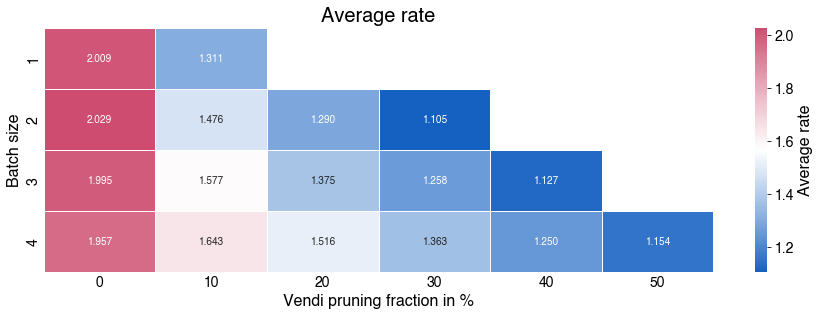

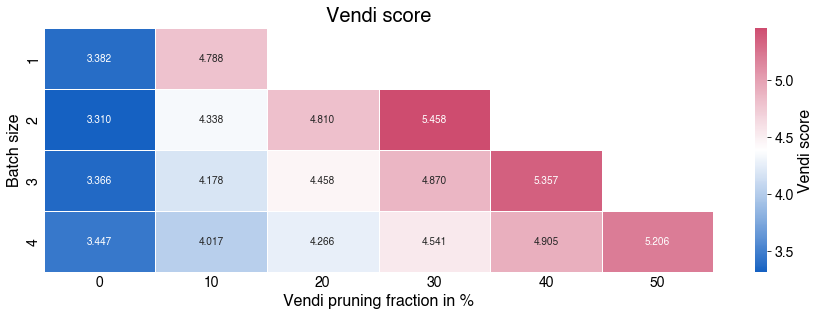

In [4]:
_,_ = generate_heatmap_summary(results_folder="./Results_Data/Reaction_Space_Size_Dependence/Full_Reaction_Space", budget=30, report_types=["vendi","rate"])

The average objective value (in this case, average rate) is highest when the amount of Vendi pruning is low whereas the Vendi score increases with increasing Vendi pruning. The two metrics therefore show opposing trends and an optimal scope that focuses on both metrics would have to find a suitable tradeoff.

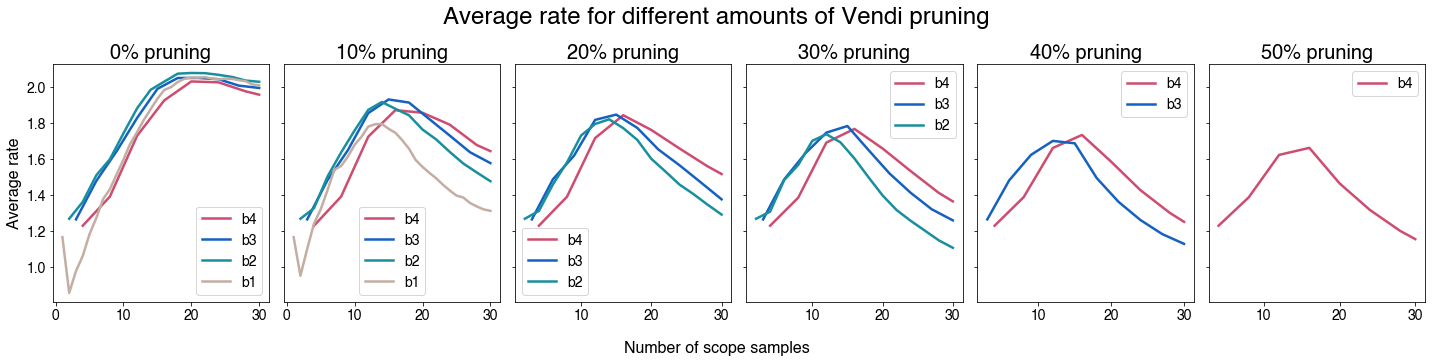

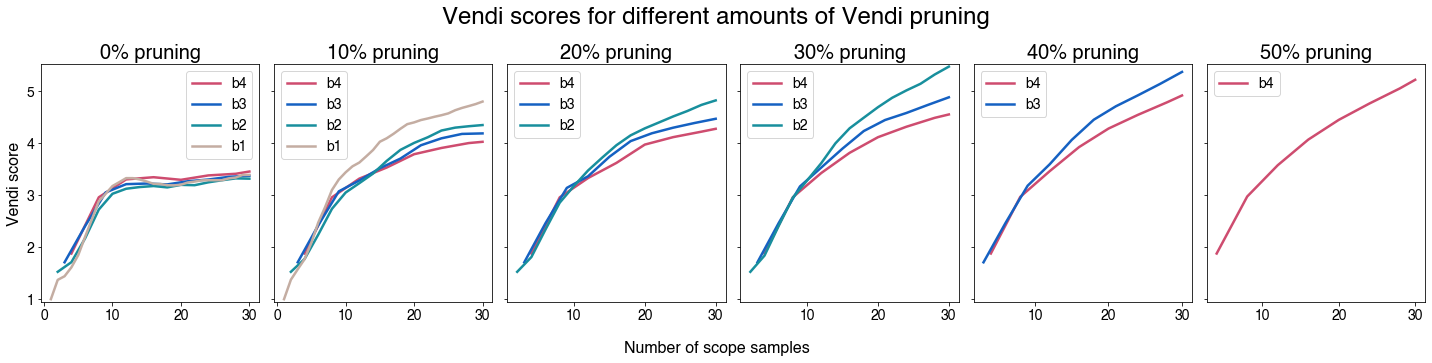

In [5]:
# process the data
for type_results in ["Objective","Vendi"]:
    dfs = {}
    for i in [4,3,2,1]:
        dfs_progress =  Benchmark().progress_plot(budget=30,type_results=type_results,name_results=f"./Results_Data/Reaction_Space_Size_Dependence/Full_Reaction_Space/30balanced_b{i}",show_plot=False)
        dfs[i] = dfs_progress["means"]
    # visualize it
    df = pd.concat(dfs,axis=1)
    df.columns = [multiindex[1] for multiindex in df.columns.to_list()]
    percentages = [0,10,20,30,40,50]
    score_min = df.min().min()
    score_max = df.max().max()
    fig, axes = plt.subplots(1, len(percentages), figsize=(20, 5), sharey=True)
    if type_results == "Objective":
        fig.suptitle("Average rate for different amounts of Vendi pruning",fontsize=24)
    elif type_results == "Vendi":
        fig.suptitle("Vendi scores for different amounts of Vendi pruning",fontsize=24)
    for i,percentage in enumerate(percentages):
        df_plot = df.copy()
        df_plot = df_plot[[column for column in df.columns if ((f"V{percentage}") in column)]]
        df_plot.columns = [col.split("_")[0] for col in df_plot.columns]
        for j,col in enumerate(df_plot.columns):
            style = '-' if j <= 6 else '--' if j <= 13 else ':'
            plotting = df_plot[col][df_plot[col].notna()]
            axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
        axes[i].set_ylim(score_min-0.05,score_max+0.05)
        axes[i].set_title(f"{percentage}% pruning",fontsize=20)
        axes[i].tick_params(labelsize=14)
        axes[i].legend(fontsize=14)
        if type_results == "Objective":
            axes[0].set_ylabel("Average rate",fontsize=16)
        else:
            axes[0].set_ylabel("Vendi score", fontsize=16)
        fig.supxlabel("Number of scope samples",fontsize=16)
        
    plt.tight_layout()
    plt.show()

Without Vendi pruning, the average rate levels off towards the end of run or even slowly starts decreasing. With increasing Vendi pruning, a maximum value is reached earlier, and the average rate then drops notably. This maximum is lower for higher amounts of pruning. Runs with smaller batch sizes reach the maximum earlier as the pruning step is applied more often (since it is conducted after every round). The performance before the maximum is reached is however similar.

In the case of the Vendi score, the score levels off without Vendi pruning, but keeps increasing if samples are pruned. The slope of that increase is larger in cases of stronger Vendi pruning and with smaller batch sizes (as the Vendi pruning is applied more often in these runs).

Due to the constraints that we set for experimental convenience (max. 30 samples, 10 rounds of experiments), only 10 experiments are allowed for a batch size of 1. As the results for this scope size are highly similar for all batch sizes and significantly lower than results obtained with larger scopes, we removed the batch size 1 from further consideration for our algorithm optimization